In [2]:
%matplotlib inline
import numpy as np

import scipy.stats as stat
import scipy.integrate as pyint
import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib import cm

# Unfolding
## Exercise 1
### Part a

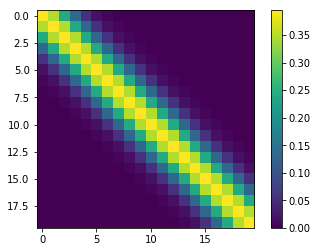

In [28]:
Nbins = 20
bin_edges = np.linspace(0,100,Nbins+1)
sigma = 2*(bin_edges[1]-bin_edges[0])
c_norm = 1./(np.sqrt(2)*sigma*pyint.quad(lambda x: np.exp(-x**2),0,100)[0])
def res_function(x,y):
    return c_norm*np.exp(-(x-y)**2/(2*sigma**2))

def int_res_fun(y,xa,xb):
    return pyint.quad(lambda x: res_function(x,y),xa,xb)[0]

bin_midpoint = .5*(bin_edges[1:]+bin_edges[:-1])
R_matrix = np.empty((Nbins,Nbins))
for i in range(Nbins):
    for j in range(Nbins):
        R_matrix[i,j]=int_res_fun(bin_midpoint[j],bin_edges[i],bin_edges[i+1])
        
plt.imshow(R_matrix)
plt.colorbar()

### Part b

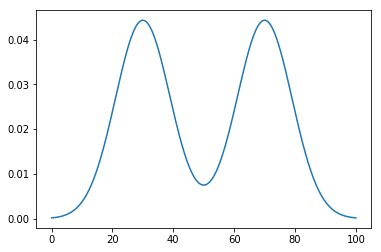

In [29]:
sigma_data = 9
c_data = 1./(np.sqrt(2)*sigma_data*pyint.quad(lambda x: np.exp(-x**2),0,100)[0])

def f_true(x):
    return .5*c_data*(np.exp(-(x-30)**2/(2*sigma_data**2))+np.exp(-(x-70)**2/(2*sigma_data**2)))

x_plot = np.linspace(0,100,1000)
plt.plot(x_plot,f_true(x_plot))

In [30]:
N = 100000
fmax = max(x_plot)
mu_sample_b = np.empty(2*N)
samples = 0
while samples<N:
    mu = 100*np.random.random(5*10**6)           
    y = fmax*np.random.random(5*10**6)
    mu = mu[y<=f_true(mu)]
    samples += len(mu)
    mu_sample_b[samples-len(mu):samples] = mu
mu_sample_b = mu_sample_b[:N]

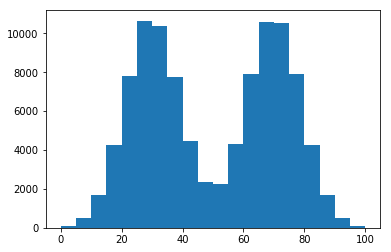

In [31]:
mu_hist, bin_edges, patches = plt.hist(mu_sample_b,bins=bin_edges)

<Container object of 20 artists>

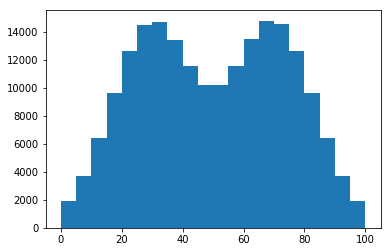

In [32]:
nu_hist = np.dot(R_matrix,mu_hist)
plt.bar(bin_midpoint,nu_hist,width=bin_edges[1]-bin_edges[0])

<Container object of 20 artists>

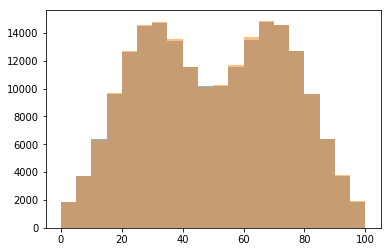

In [33]:
N_d = len(nu_hist)
poisson = stat.poisson(nu_hist)
Nexperiment_d = poisson.rvs(N_d)
plt.figure()
plt.bar(bin_midpoint,nu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5)
plt.bar(bin_midpoint,Nexperiment_d,width=bin_edges[1]-bin_edges[0],alpha=0.5)

### Part e

<Container object of 20 artists>

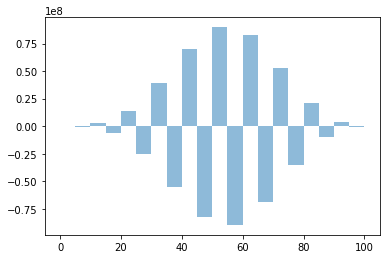

In [34]:
R_inv = np.linalg.inv(R_matrix)
mu_estimated_inv = np.dot(R_inv,Nexperiment_d)
plt.figure()
plt.bar(bin_midpoint,mu_estimated_inv,width=bin_edges[1]-bin_edges[0],alpha=0.5)
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5)

### Part f

In [37]:
def chi2_mu_hist(mu_hist_try):
    nu_hist_try = np.dot(R_matrix,mu_hist_try)
    logp_i = (nu_hist_try-Nexperiment_d)**2/Nexperiment_d
    return sum(logp_i)

bound_f = tuple([(0,None) for i in range(N_d)])
minimization_chi = opt.minimize(chi2_mu_hist,Nexperiment_d,bounds=bound_f)
mu_estimated_chi = minimization_chi['x']

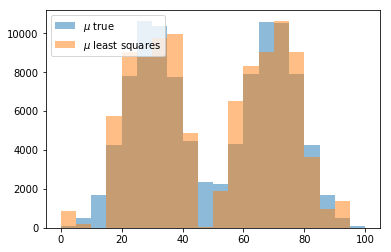

In [38]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,mu_estimated_chi,width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ least squares')
plt.legend()

In [39]:
def like_mu_hist(mu_hist_try):
    nu_hist_try = np.dot(R_matrix,mu_hist_try)
    logp_i = nu_hist_try-Nexperiment_d*(np.log(nu_hist_try)+np.log(Nexperiment_d)-1)
    return np.sum(logp_i)

bound_f = tuple([(0,None) for i in range(N_d)])
minimization_like = opt.minimize(like_mu_hist,Nexperiment_d,bounds=bound_f)
mu_estimated_like = minimization_like['x']

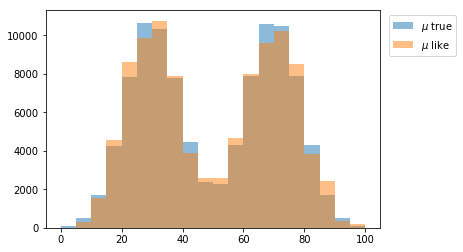

In [50]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,mu_estimated_like,width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ like')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

## Correction factors
It s based on an iteration that does not converge! Yay!

In [69]:
N_g = 10
mus_g = np.empty((N_g+1,len(Nexperiment_d)))
nus_g = np.empty((N_g,len(Nexperiment_d)))
mus_g[0,:] = Nexperiment_d
for i in range(N_g):
    nus_g[i,:] = np.dot(R_matrix,mus_g[i,:])
    c = mus_g[i,:]/nus_g[i,:]
    mus_g[i+1,:] = c*Nexperiment_d

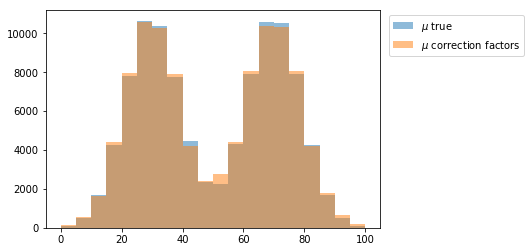

In [70]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,mus_g[-1,:],width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ correction factors')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

## Forward unfolding

In [75]:
def f_param(x,theta):
    mean1,mean2,s1,s2,norm = theta
    return norm*(np.exp(-(x-mean1)**2/(2*s1**2))+np.exp(-(x-mean2)**2/(2*s2**2)))

def chi2_forward(theta):
    nu_i = np.dot(R_matrix,f_param(bin_midpoint,theta))
    chi = (nu_i-Nexperiment_d)**2/Nexperiment_d
    return sum(chi)

In [80]:
minimization_fow = opt.minimize(chi2_forward,(20,60,5,15,5000))
theta_estimated_fow = minimization_fow['x']
print theta_estimated_fow

[  2.99689072e+01   6.98849354e+01   9.03002830e+00   9.18389041e+00
   1.10094764e+04]


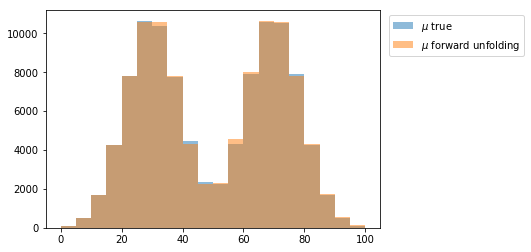

In [81]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,f_param(bin_midpoint,theta_estimated_fow),width=bin_edges[1]-bin_edges[0],
        alpha=0.5, label= '$\mu$ forward unfolding')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

# Exercise 2

## Part a
Done in ex1
## Part b
we are going to use maximum entropy
## Part c

In [103]:
def s_mu_eq7(mu_try):
    mu_tot = sum(mu_try)
    p = mu_try/mu_tot
    return -sum(p*np.log(p))

n_tot = sum(Nexperiment_d)
def eq7_max_entropy(mu_try,alpha,landa):
    return -alpha*like_mu_hist(mu_try)+s_mu_eq7(mu_try)+landa*(sum(np.dot(R_matrix,mu_try))-n_tot)

In [105]:
alphavec = np.logspace(-1,12,10)
mus_reg = np.empty((len(alphavec),len(Nexperiment_d)))
lambdas_reg = np.empty(len(alphavec))
bound_f = tuple([(0,None) for i in range(N_d)]+[(None,None)])
for i,alpha in enumerate(alphavec):
    res_alph = opt.minimize(lambda mulanda: -eq7_max_entropy(mulanda[:-1],alpha,mulanda[-1]),
                            np.append(Nexperiment_d,5),bounds=bound_f)
    mus_reg[i,:] = res_alph['x'][:-1]
    lambdas_reg[i] = res_alph['x'][-1]

C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [106]:
np.savetxt('mus_reg_2.dat',mus_reg)
np.savetxt('alphas_reg_2.dat',alphavec)
np.savetxt('lambdas_reg_2.dat',lambdas_reg)

## Part d

In [116]:
V = np.eye(N_d)*Nexperiment_d
A = np.zeros((N_d+1,N_d+1))
B = np.ones((N_d+1,N_d))
delta = np.eye(N_d)
k=0
mutot=sum(mus_reg[k,:])
for i in range(N_d):
    A[i,N_d] = -sum(R_matrix[:,i])
    A[N_d,i] = -sum(R_matrix[:,i])
    B[i,:] = R_matrix[i,:]/np.dot(R_matrix,mus_reg[k,:])
    for j in range(N_d):
        A[i,j]=-alphavec[k]*sum(Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]/np.dot(R_matrix,mus_reg[k,:])**2)+(1.
                -delta[i,j]*mutot/mus_reg[k,i]+np.log(mus_reg[k,i]*mus_reg[k,j]/mutot)+2*s_mu_eq7(mus_reg[k,:]))/mutot**2

C = -np.dot(np.linalg.inv(A),B)
U = np.dot(np.dot(C,V),np.transpose(C))

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19)]
